In [101]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/rbig/')

from rbig.univariate import MarginalUniformization, InverseCDF
from rbig.data import ToyData
from rbig.linear import LinearTransform
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

[[2.17126121 0.70097607]
 [1.99469089 0.88019929]
 [0.565957   0.45132916]
 ...
 [0.94453283 0.66993922]
 [1.16392873 1.02281901]
 [1.94122573 0.96910009]]


<Figure size 360x360 with 0 Axes>

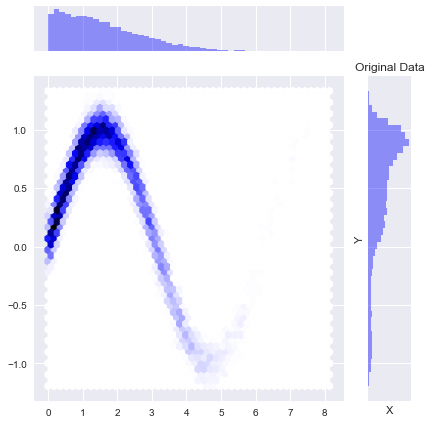

In [132]:
seed = 123
rng = np.random.RandomState(seed=seed)

data = ToyData('rbig', 10000, 0.1, 123).generate_samples()
print(data)
X = data[:, 0]
Y = data[:, 1]
# num_samples = 5000
# x = np.abs(2 * rng.randn(1, num_samples))
# y = np.sin(x) + 0.25 * rng.randn(1, num_samples)
# data = np.vstack((x, y)).T

fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

### Step I - Histogram Transform

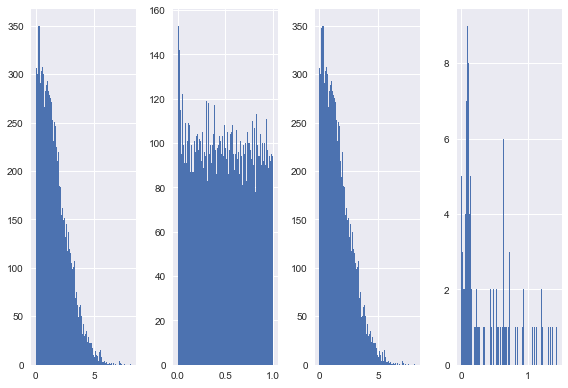

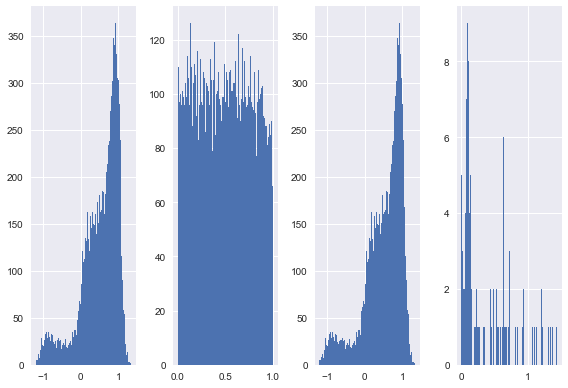

<Figure size 360x360 with 0 Axes>

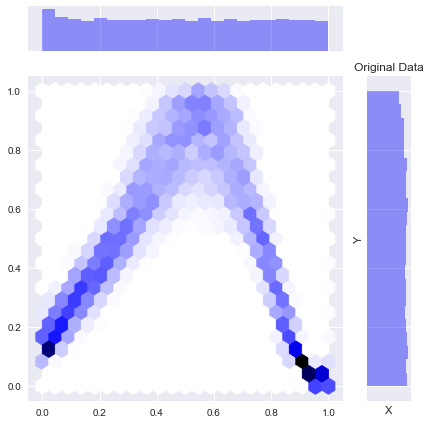

In [133]:
# X
muni_model = MarginalUniformization()
muni_model.fit(X);

X_uni = muni_model.transform(X)
X_approx = muni_model.inverse_transform(X_uni)

muni_model = MarginalUniformization()
muni_model.fit(Y);

fig, ax = plt.subplots(ncols=4)

ax[0].hist(X, bins=100)
ax[1].hist(X_uni, bins=100)
ax[2].hist(X_approx, bins=100)
ax[3].hist(muni_model.hpdf, bins=100)
plt.tight_layout()
plt.show()

# Y
Y_uni = muni_model.transform(Y)
Y_approx = muni_model.inverse_transform(Y_uni)


logpdf = muni_model.logpdf(X)
X_uni.min(), X_uni.max()

fig, ax = plt.subplots(ncols=4)

ax[0].hist(Y, bins=100)
ax[1].hist(Y_uni, bins=100)
ax[2].hist(Y_approx, bins=100)
ax[3].hist(muni_model.hpdf, bins=100)
plt.tight_layout()
plt.show()

# X, Y
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=X_uni, y=Y_uni, kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

### Step II - Inverse Normal CDF

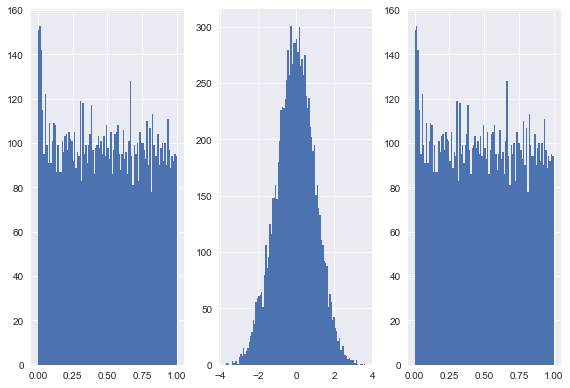

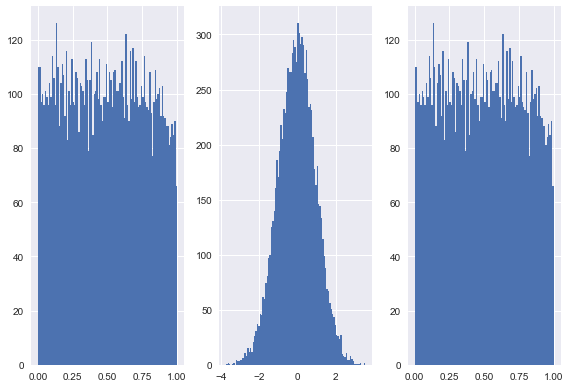

<Figure size 360x360 with 0 Axes>

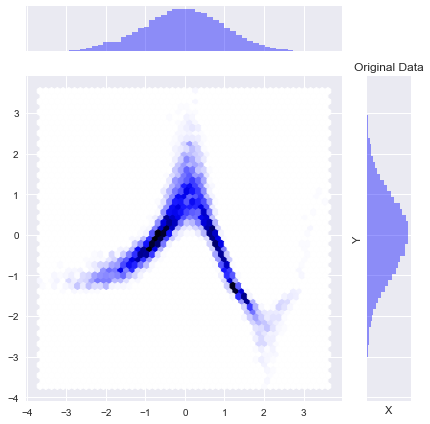

In [134]:
# X
X_gauss = InverseCDF().transform(X_uni)
X_uni_approx = InverseCDF().inverse_transform(X_gauss)


fig, ax = plt.subplots(ncols=3)

ax[0].hist(X_uni, bins=100)
ax[1].hist(X_gauss, bins=100)
ax[2].hist(X_uni_approx, bins=100)
plt.tight_layout()
plt.show()

# Y
Y_gauss = InverseCDF().transform(Y_uni)
Y_uni_approx = InverseCDF().inverse_transform(Y_gauss)


fig, ax = plt.subplots(ncols=3)

ax[0].hist(Y_uni, bins=100)
ax[1].hist(Y_gauss, bins=100)
ax[2].hist(Y_uni_approx, bins=100)
plt.tight_layout()
plt.show()

# X, Y
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=X_gauss, y=Y_gauss, kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

### Step III - Rotation

In [135]:
data_gauss = np.vstack([X_gauss, Y_gauss]).T
data_gauss.shape

(10000, 2)

In [142]:
rotation_trans = LinearTransform()
# data_gauss = np.hstack([X_gauss, Y_gauss])
rotation_trans.fit(data_gauss)

X_rot = rotation_trans.transform(data_gauss)

X_gauss_approx = rotation_trans.inverse_transform(X_rot)

In [146]:
l_prob = rotation_trans.logdetjacobian()
print(l_prob)

l_prob = rotation_trans.logdetjacobian(data_gauss)
print(l_prob)

2.7755575615628914e-17
[[2.77555756e-17 2.77555756e-17]]


<Figure size 360x360 with 0 Axes>

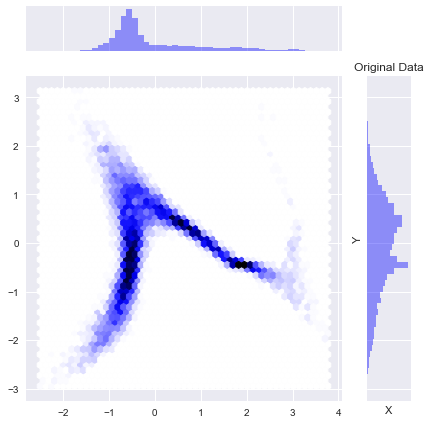

<Figure size 360x360 with 0 Axes>

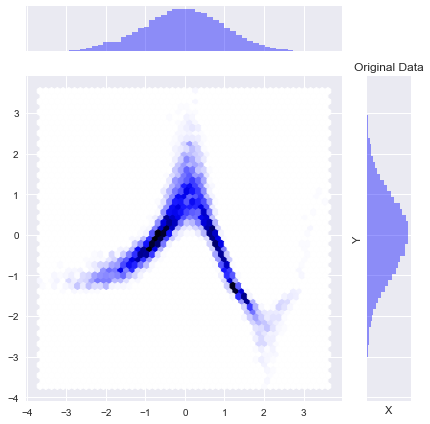

In [143]:
# X, Y
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=X_rot[:, 0], y=X_rot[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=X_gauss_approx[:, 0], y=X_gauss_approx[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

In [80]:
# Parameters
bins_est = 'sqrt'
pdf_extension = 0.1
cdf_precision = 1000
alpha = 1e-6    # regularization parameter 

histogram_params = None 

data_uni = list()
models = list()
for idata in range(data.shape[-1]):
    
    # Initialize Model
    uni_model = MarginalUniformization(
        bins_est=bins_est, 
        pdf_extension=pdf_extension, 
        cdf_precision=cdf_precision, 
        alpha=alpha
    )

    # Fit Model to Data
    uni_model.fit(data[:, idata])

    # Transform Data to Uniform Space
    X_uni_approx = uni_model.transform(X)
    models.append(uni_model)
    data_uni.append(X_uni_approx.squeeze())

data_uni = np.asarray(data_uni).T

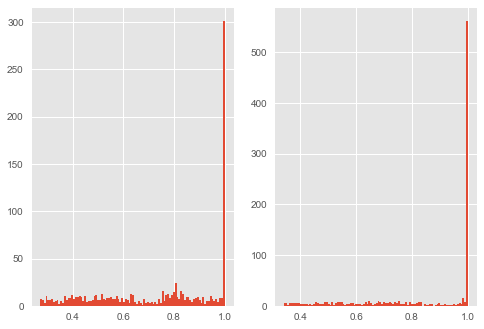

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(data_uni[:, 0], bins=100)
ax[1].hist(data_uni[:, 1], bins=100)
plt.show()

In [82]:
X_approx = list()
for i, imodel in enumerate(models):
    X_ = imodel.inverse_transform(data_uni[:, i])
    X_approx.append(X_)
    
X_approx = np.asarray(X_approx)

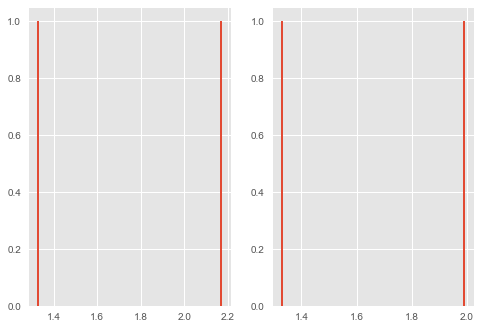

<Figure size 360x360 with 0 Axes>

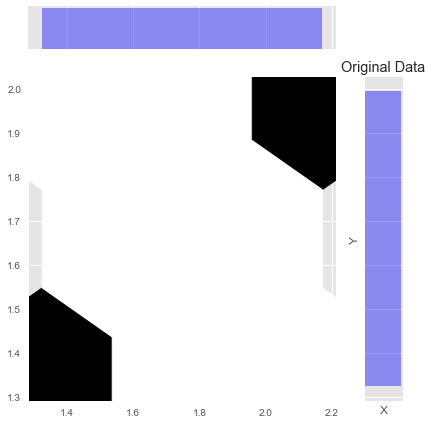

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(X_approx[:, 0], bins=100)
ax[1].hist(X_approx[:, 1], bins=100)
plt.show()

fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=X_approx[:, 0], y=X_approx[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()

In [84]:
data_uni.shape

(1000, 2)

<Figure size 360x360 with 0 Axes>

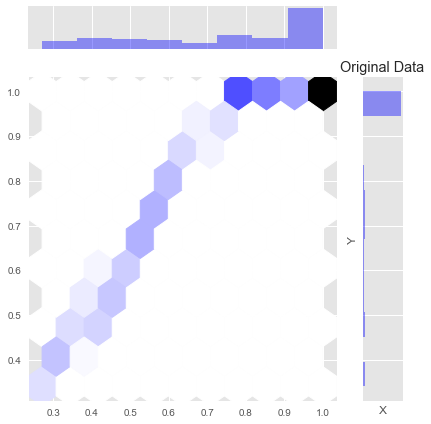

In [85]:
fig  = plt.figure(figsize=(5, 5))

g = sns.jointplot(x=data_uni[:, 0], y=data_uni[:, 1], kind='hex', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.tight_layout()
plt.show()